In [6]:
import numpy as np
import matplotlib.pyplot as plt
#import scipy
import time

In [7]:
#import MatrixProductFunctions as mps

### Функция, используемая при сжатии MPS

In [8]:
def zero_filter(num):
    if num > 1e-8:
        return True
    else:
        return False    

### Перевод состояния из векторной формы в форму MPS 

In [9]:
def vec_to_MPS(psi_vec):
    n = int(np.log2(len(psi_vec)))
    tensors = []
    shape = (2, 2**(n-1))
    psi_matrix = psi_vec.reshape(shape)
    for i in range(0,n-1):
        psi_svd = np.linalg.svd(psi_matrix,full_matrices=False)
        l = len(list(filter(zero_filter, psi_svd.S))) # Находим, сколько ненулевых элементов в матрице S
        psi_svd_U = psi_svd.U.reshape(int(psi_svd.U.shape[0]/2),2,int(psi_svd.U.shape[1])) # Переводим матрицу U в тензор
        psi_svd_U = psi_svd_U[:,:,:l] # Обрезаем лишние столбцы в матрице U
        tensors.append(psi_svd_U)
        psi_svd_S = psi_svd.S[:l] # Убираем из S нулевые значения
        pmatrix = np.diag(psi_svd_S) @ psi_svd.Vh[:l,:] # Обрезаем лишние строки в матрице Vh и перемножаем изменённые матрицы S и Vh
        psi_matrix = pmatrix.reshape(int(pmatrix.shape[0]*2),int(pmatrix.shape[1]/2))    
    psi_svd_U = pmatrix.reshape(int(pmatrix.shape[0]),2,int(pmatrix.shape[1]/2))
    tensors.append(psi_svd_U)
    return tensors

### Сравнение двух состояний в векторной форме

In [10]:
def identity(num1,num2):
    return num1 @ num2 / (np.linalg.norm(num1) * np.linalg.norm(num2))

### Сложение состояний в форме MPS

In [11]:
def mps_sum(psi_one, psi_two):
    common_tensor = []
    common_tensor.append(np.concatenate([psi_one[0],psi_two[0]],axis = 2).reshape(1,2,psi_one[0].shape[2]+psi_two[0].shape[2]))
    for i in range(1,len(psi_one)-1):
        zero_arr1 = np.zeros((psi_two[i].shape[0],2,psi_one[i].shape[2]))
        zero_arr2 = np.zeros((psi_one[i].shape[0],2,psi_two[i].shape[2]))
        ff1 = np.concatenate([psi_one[i],zero_arr1],axis=0).reshape(psi_two[i].shape[0]+psi_one[i].shape[0],2,psi_one[i].shape[2])
        ff2 = np.concatenate([zero_arr2,psi_two[i]],axis=0).reshape(psi_two[i].shape[0]+psi_one[i].shape[0],2,psi_two[i].shape[2])
        new_element = np.concatenate([ff1, ff2],axis = 2).reshape(psi_two[i].shape[0]+psi_one[i].shape[0],2,psi_two[i].shape[2]+psi_one[i].shape[2])
        common_tensor.append(new_element)
    common_tensor.append(np.concatenate([psi_one[-1],psi_two[-1]],axis = 0).reshape(psi_one[-1].shape[0]+psi_two[-1].shape[0],2,1))
    return common_tensor

### Сжатие состояния в форме MPS

In [12]:
def mps_compression(absnew_tensor):
    abs_absnew_tensor = [] # Создаём лист для хранения тензоров
    ten_ten = [absnew_tensor[-1]]
    for i in range(len(absnew_tensor)-1):
        shapi = ten_ten[0].shape
        element = ten_ten[-1].reshape(shapi[0],shapi[1]*shapi[2]) # Переводим тензор в матрицу
        element_svd = np.linalg.svd(element,full_matrices=False) # Делаем сингулярное разложение матрицы
        b_tensor = element_svd.Vh.reshape(element_svd.Vh.shape[0],shapi[1],shapi[2]) # Переводим матрицу Vh в тензор
        l = len(list(filter(zero_filter, element_svd.S))) # Находим условие обрезания матриц и тензоров
        b_tensor = b_tensor[:l,:,:] # Обрезаем тензор
        abs_absnew_tensor.append(b_tensor) # Вносим тензор в лист хранения тензоров
        element_svd_S = element_svd.S[:l] # Обрезаем матрицу S
        newpmatrx = element_svd.U[:,:l] @ np.diag(element_svd_S) # Обрезаем матрицу U и умножаем на матрицу S
        pmatrix = np.tensordot(absnew_tensor[-2-i], newpmatrx,axes = 1) # Перемножаем более левый тензор с перемноженными матрицами U и S
        ten_ten = [pmatrix]
    abs_absnew_tensor.append(pmatrix) # Добавляем последний тензор в лист хранения тензоров
    abs_absnew_tensor[::] = abs_absnew_tensor[::-1] # Инвертируем порядок хранения листа хранения
    return abs_absnew_tensor

### Перевод состояния из векторной формы в левую каноническую форму MPS с помощью QR-разложения

In [13]:
def QR_decomposition(psi):
    n = int(np.log2(len(psi)))
    arr_store = []
    shape = (2,2**(n-1))
    psi_matrix = psi.reshape(shape)
    for i in range(0,n-1):
        Q, R = np.linalg.qr(psi_matrix, mode = 'reduced')
        Q_reshaped = Q.reshape(int(Q.shape[0]/2),2,int(Q.shape[1])) # Переводим матрицу Q в тензор
        arr_store.append(Q_reshaped)
        pmatrix = R 
        psi_matrix = pmatrix.reshape(int(pmatrix.shape[0]*2),int(pmatrix.shape[1]/2))    
    Q = pmatrix.reshape(int(pmatrix.shape[0]),2,int(pmatrix.shape[1]/2))
    arr_store.append(Q)
    return arr_store

### Перевод состояния из векторной формы в правую каноническую форму MPS с помощью QR-разложения

In [14]:
def QR_rc_decomposition(psi):
    n = int(np.log2(len(psi)))
    arr_store = []
    shape = (2**(n-1), 2)
    psi_matrix = psi.reshape(shape)
    for i in range(0,n-1):
        Q, R = np.linalg.qr(psi_matrix.T, mode = 'reduced')
        Q_reshaped = Q.T.reshape(int(Q.T.shape[0]),2,int(Q.T.shape[1]/2)) # Переводим матрицу Q в тензор
        arr_store.append(Q_reshaped)
        pmatrix = R.T 
        psi_matrix = pmatrix.reshape(int(pmatrix.shape[0]/2),int(pmatrix.shape[1]*2))    
    Q = pmatrix.reshape(int(pmatrix.shape[0]/2),2,int(pmatrix.shape[1]))
    arr_store.append(Q)
    return arr_store[::-1]

### Перевод имеющегося MPS в левую каноническую форму

In [15]:
def left_canonical_MPS(mps):
    common_tensor = mps
    absnew_tensor = [] # Создаём лист для хранения тензоров
    ten_ten = [common_tensor[0]]
    for i in range(len(common_tensor)-1):
        shapi = ten_ten[0].shape
        element = ten_ten[0].reshape(shapi[0]*shapi[1],shapi[2]) # Переводим тензор в матрицу
        element_q, element_r = np.linalg.qr(element) # Делаем сингулярное разложение матрицы
        aa_tensor = element_q.reshape(shapi[0],shapi[1],-1) # Переводим матрицу Vh в тензор   
        absnew_tensor.append(aa_tensor) # Вносим тензор в лист хранения тензоров   
        newpmatrx = element_r
        pmatrix = np.tensordot(newpmatrx, common_tensor[i+1],axes = 1) # Перемножаем более левый тензор с перемноженными матрицами U и S
        ten_ten = [pmatrix]
    absnew_tensor.append(pmatrix) # Добавляем последний тензор в лист хранения тензоров
    return absnew_tensor

### Поэлементное умножение двух состояний в форме MPS

In [16]:
def el_by_el_multiplication(tensors_1, tensors_2):
    mult_tensor = []
    for i in range(len(tensors_1)):
        sh1 = tensors_1[i].shape
        sh2 = tensors_2[i].shape
        mult_tensor.append(np.einsum('ijk,mjl->imjkl', tensors_1[i], tensors_2[i]).reshape(sh1[0]*sh2[0], 2, sh1[2]*sh2[2]))
    return mult_tensor

### Скалярное умножение двух состояний в форме MPS

In [17]:
def mps_scalar_multiplication(mps_1, mps_2):
    tensors_1 = mps_1
    tensors_2 = mps_2
    sh1 = tensors_1[0].shape
    sh2 = tensors_2[0].shape
    nnn = np.einsum('ijk,mjl->imkl', tensors_1[0], tensors_2[0]).reshape(sh1[0]*sh2[0], sh1[2]*sh2[2])
    for i in range(1, len(tensors_1)):
        sh1 = tensors_1[i].shape
        sh2 = tensors_2[i].shape
        nnn = nnn @ np.einsum('ijk,mjl->imkl', tensors_1[i], tensors_2[i]).reshape(sh1[0]*sh2[0], sh1[2]*sh2[2])
    nnn = nnn.reshape(-1)[0]
    return nnn

### Аналитическая запись оператора производной в форме MPO

In [18]:
def der_mpo(n):
    der_mpo_list = []
    mpo_derivative_first = 0.5 * np.array([1,0,0,0,1,0,0,0,-1,1,0,0]).reshape(1,2,2,3)
    mpo_derivative_last = np.array([0,1,-1,0,0,0,1,0,0,1,0,0]).reshape(3,2,2,1)
    mpo_derivative_intermediate = np.array([1,0,0,0,1,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]).reshape(3,2,2,3)
    der_mpo_list.append(mpo_derivative_first)
    for i in range(n-2):
        der_mpo_list.append(mpo_derivative_intermediate)
    der_mpo_list.append(mpo_derivative_last)
    return der_mpo_list

### Аналитическая запись оператора второй производной в форме MPO

In [19]:
def der2_mpo(n):
    mpo_derivative2_first = np.array([1,0,0,0,1,0,0,0,1,1,0,0]).reshape(1,2,2,3)
    mpo_derivative2_last = np.array([-2,1,1,-2,0,0,1,0,0,1,0,0]).reshape(3,2,2,1)
    mpo_derivative2_intermediate = np.array([1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]).reshape(3,2,2,3)
    a_first2 = mpo_derivative2_first
    for i in range(n-2):
        a_first2 = np.tensordot(a_first2, mpo_derivative2_intermediate, axes = 1)
    a_end = np.tensordot(a_first2, mpo_derivative2_last, axes = 1)
    a_end = a_end.reshape(2*np.ones(2*n, dtype = int))
    sh_t = np.arange(0,2*n,2)
    shh_t = np.arange(1,2*n,2)
    sh_t = list(np.concatenate((sh_t, shh_t)))
    a_end = np.transpose(a_end, axes = sh_t)
    a_end = a_end.reshape(2**n,2**n)
    return a_end

### Матрица производной через свёртку

In [20]:
def der_matrix(n):
    mpo_derivative_first = 0.5 * np.array([1,0,0,0,1,0,0,0,-1,1,0,0]).reshape(1,2,2,3)
    mpo_derivative_last = np.array([0,1,-1,0,0,0,1,0,0,1,0,0]).reshape(3,2,2,1)
    mpo_derivative_intermediate = np.array([1,0,0,0,1,0,0,0,-1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0]).reshape(3,2,2,3)
    a_first = mpo_derivative_first
    for i in range(n-2):
        a_first = np.tensordot(a_first, mpo_derivative_intermediate, axes = 1)
    a_end = np.tensordot(a_first, mpo_derivative_last, axes = 1)
    a_end = a_end.reshape(2*np.ones(2*n, dtype = int))
    sh_t = np.arange(0,2*n,2)
    shh_t = np.arange(1,2*n,2)
    sh_t = list(np.concatenate((sh_t, shh_t)))
    a_end.shape
    a_end = np.transpose(a_end, axes = sh_t)
    a_end = a_end.reshape(2**n,2**n)
    return a_end

### Перевод MPO в форму матрицы

In [21]:
def mpo_to_matrix(mpo):
    mul = mpo[0]
    for i in range(1, len(mpo)):
        mul = np.tensordot(mul, mpo[i], axes = 1)
    mul = mul.reshape(2 * np.ones(2 * len(mpo), dtype = int))
    sh_t = np.arange(0, 2 * len(mpo), 2)
    shh_t = np.arange(1, 2 * len(mpo), 2)
    sh_t = list(np.concatenate((sh_t, shh_t)))
    mul = np.transpose(mul, axes = sh_t)
    mul = mul.reshape(2**(len(mpo)), 2**(len(mpo)))
    return mul

### Аналитическая запись x^2 в виде MPS

In [22]:
def x2_mps(n):
    mps_x2_first = np.array([1,0,0,1,1,1]).reshape(1,2,3)
    mps_x2_last = np.array([0,1,0,4,4,4]).reshape(3,2,1)
    a_first3 = mps_x2_first
    for i in range(1,n-1):
        mps_x2_intermediate = np.array([1,0,0,1,1,1,0,2,0,0,2,4,0,0,4,0,0,4]).reshape(3,2,3)
        a_first3 = np.tensordot(a_first3, mps_x2_intermediate, axes = 1)
    a_end = np.tensordot(a_first3, mps_x2_last, axes = 1)
    a_end = a_end.reshape(-1)
    return a_end

### Аналитическая запись x через MPS

In [23]:
def x_mps(n):
    x_mps = []
    mps_x_first = np.array([1,0,1,1]).reshape(1,2,2)
    mps_x_last = np.array([0,1,2,2]).reshape(2,2,1)
    mps_x_intermediate = np.array([1,0,1,1,0,2,0,2]).reshape(2,2,2)
    return [mps_x_first] + [mps_x_intermediate] * (n - 2) + [mps_x_last]

In [24]:
def x_vector(n):
    mps_x_first = np.array([1,0,1,1]).reshape(1,2,2)
    mps_x_last = np.array([0,1,2,2]).reshape(2,2,1)
    mps_x_intermediate = np.array([1,0,1,1,0,2,0,2]).reshape(2,2,2)
    a_first4 = mps_x_first
    for i in range(n-2):
        a_first4 = np.tensordot(a_first4, mps_x_intermediate, axes = 1)
    a_end = np.tensordot(a_first4, mps_x_last, axes = 1)
    a_end = a_end.reshape(-1)
    return a_end

### Аналитическая запись оператора X через MPO

In [25]:
def x_mpo(n, x0 = 0):
    x_mpo_first = np.array([1, 0, 0, 0, 0, 0, 1, 1]).reshape(1, 2, 2, 2)
    x_mpo_intermediate = np.array([1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2]).reshape(2, 2, 2, 2)
    x_mpo_last = np.array([x0, 0, 0, x0 + 1, 2, 0, 0, 2]).reshape(2, 2, 2, 1)
    x_mpo_list = []
    x_mpo_list.append(x_mpo_first)
    for i in range(n-2):
        x_mpo_list.append(x_mpo_intermediate)
    x_mpo_list.append(x_mpo_last)
    return x_mpo_list

### Запись матрицы X через свёртку MPO

In [26]:
def x_matrix(n, x0 = 0):
    x_mpo_first = np.array([1, 0, 0, 0, 0, 0, 1, 1]).reshape(1, 2, 2, 2)
    x_mpo_intermediate = np.array([1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2]).reshape(2, 2, 2, 2)
    x_mpo_last = np.array([x0, 0, 0, x0 + 1, 2, 0, 0, 2]).reshape(2, 2, 2, 1)
    st_first = x_mpo_first
    for i in range(n-2):
        st_first = np.tensordot(st_first, x_mpo_intermediate, axes = 1)
    st_end = np.tensordot(st_first, x_mpo_last, axes = 1)
    st_end = st_end.reshape(2*np.ones(2*n, dtype = int))
    sh_t = np.arange(0,2*n,2)
    shh_t = np.arange(1,2*n,2)
    sh_t = list(np.concatenate((sh_t, shh_t)))
    st_end = np.transpose(st_end, axes = sh_t)
    st_end = st_end.reshape(2**n,2**n)
    return(st_end)

### Аналитическая запись экспоненты в виде MPS

In [27]:
def exp_mps(n, alpha, step):
    exp_mps = []
    for i in range(n):
        exp_mps.append(np.array([1, np.exp(step * alpha * 2**(n-i-1))]).reshape(1,2,1))
    return exp_mps

### Аналитическая запись экспоненты от begin до end в виде MPS

In [28]:
def exp_mps_smart(n, step, begin, end):
    exp_mps = []
    alpha = (end - begin)/2**n
    for i in range(n):
        exp_mps.append(np.array([1, np.exp(step * alpha * 2**(n + begin - i - 1))]).reshape(1,2,1))
    return exp_mps

### Перевод состояния из формы MPS в векторную форму

In [29]:
def tensors_multiplication(tensors):
    tensor_second = tensors[0]
    for i in range(len(tensors)-1):
        tensor_second = np.tensordot(tensor_second,tensors[i+1],axes = 1)
    return tensor_second.reshape(-1)

### Гауссовое состояние в форме MPS (несимметричное)

In [30]:
def gauss_mps(n, l, alpha):
    x_base = np.arange(2**n)
    x_squared = x_base**2
    gauss_state = np.exp(-alpha*x_squared)
    gauss_n = QR_decomposition(gauss_state) # Нахождение MPS для гауссого состояния при некотором начальном n
    for i in range(l):
        gauss_n_one = [np.array([1,0]).reshape(1,2,1)] + gauss_n
        gauss_n_two = gauss_n
        gauss_n_two[0] = gauss_n_two[0] * np.exp(-alpha * 4**(n + i))
        gauss_n_two = el_by_el_multiplication(gauss_n_two, exp_mps(n + i, alpha, -2**(n + 1 + i)))
        gauss_n_two = [np.array([0,1]).reshape(1,2,1)] + gauss_n_two
        new_gauss_mps = mps_sum(gauss_n_one, gauss_n_two)
        gauss_n = mps_compression(new_gauss_mps)
    return gauss_n

### Гауссовое состояние в форме MPS (симметричное)

In [31]:
def sym_gauss_mps(x_bond, n):
    alpha = x_bond / 4**(n-1)
    j = 3
    first_part = gauss_mps(j, n - j - 1, alpha)
    second_part = []
    for i in first_part:
        second_part.append(i[:,::-1,:])
    first_part = [np.array([0,1]).reshape(1,2,1)] + first_part
    second_part = [np.array([1,0]).reshape(1,2,1)] + second_part
    sym_gauss = mps_sum(first_part, second_part)
    return sym_gauss

### Решение СЛУ в форме MPS и MPO (1 проход вправо и 1 проход влево)

In [32]:
def mp_solve(mpo, mps_rp, mps_initial):
    n = len(mpo)
    
    mps_train = mps_initial.copy()
    if len(mps_train[0].shape) == 3:
        mps_train[-1] = mps_train[-1].reshape(mps_train[-1].shape[0], mps_train[-1].shape[1])
        mps_train[0] = mps_train[0].reshape(mps_train[0].shape[1], mps_train[0].shape[2])

    mpo_train = mpo.copy()
    if len(mpo_train[0].shape) == 4:
        mpo_train[-1] = mpo_train[-1].reshape(mpo_train[-1].shape[0], mpo_train[-1].shape[1], mpo_train[-1].shape[2])
        mpo_train[0] = mpo_train[0].reshape(mpo_train[0].shape[1], mpo_train[0].shape[2], mpo_train[0].shape[3])

    b_mps = mps_rp.copy()
    if len(b_mps[0].shape) == 3:
        b_mps[0] = b_mps[0].reshape(b_mps[0].shape[1], b_mps[0].shape[2])
        b_mps[-1] = b_mps[-1].reshape(b_mps[-1].shape[0], b_mps[-1].shape[1])

    first_layer = np.einsum('ij, njr, qr -> inq', mps_train[-1], mpo_train[-1], mps_train[-1])
    layer_one = first_layer

    first_r_layer = np.einsum('ij, kj -> ik', b_mps[-1], mps_train[-1])
    lay_one = first_r_layer

    right_layers = []
    right_layers.append(first_layer)
    for i in range(2, n-1):
        new_layer = np.einsum('abc, ija -> ijbc', layer_one, mps_train[-i])
        new_layer = np.einsum('abcd, ibjc -> aijd', new_layer, mpo_train[-i])
        new_layer = np.einsum('abcd, icd -> abi', new_layer, mps_train[-i])
        right_layers.append(new_layer)
        layer_one = new_layer

    right_r_layers = []
    right_r_layers.append(first_r_layer)
    for i in range(2, n-1):
        new_r_layer = np.einsum('ab, ija -> ijb', lay_one, b_mps[-i])
        new_r_layer = np.einsum('abc, ibc -> ai', new_r_layer, mps_train[-i])
        right_r_layers.append(new_r_layer)
        lay_one = new_r_layer

    first_step = np.einsum('abc, ijkb, dei -> ajdcke', right_layers[-1], mpo_train[1], mpo_train[0])
    f_sh = first_step.shape
    first_step = first_step.reshape(f_sh[0] * f_sh[1] * f_sh[2], f_sh[3] * f_sh[4] * f_sh[5])

    first_step_v = np.einsum('ab, ija, ci -> bjc', right_r_layers[-1], b_mps[1], b_mps[0])
    first_step_v = first_step_v.reshape(-1)

    t_1 = np.linalg.solve(first_step, first_step_v)
    t_1 = t_1.reshape(2, -1)
    t_1_svd = np.linalg.svd(t_1, full_matrices = False)
    l = len(list(filter(zero_filter, t_1_svd.S))) 
    t_1_svd_U = t_1_svd.U.reshape(2, -1)
    t_1_svd_U = t_1_svd_U[:, :l]
    mps_train[0] = t_1_svd_U

    last_layer = np.einsum('ij, ilq, lr -> jqr', mps_train[0], mpo_train[0], mps_train[0])
    layer_last = last_layer

    last_r_layer = np.einsum('ij, ik -> jk', b_mps[0], mps_train[0])
    lay_last = last_r_layer

    left_layers = []
    left_layers.append(last_layer)

    left_r_layers = []
    left_r_layers.append(last_r_layer)

    for i in range(n-3):
        # Вычисляем матрицу
        t_inter = np.einsum("abc, ijk, bopw, wefj -> aoeicpfk", left_layers[i], right_layers[- 2 - i], mpo_train[i + 1], mpo_train[i + 2])
        shape_t = t_inter.shape
        t_inter = t_inter.reshape(shape_t[0] * shape_t[1] * shape_t[2] * shape_t[3], shape_t[4] * shape_t[5] * shape_t[6] * shape_t[7])
        # Вычисляем правую часть СЛУ
        rp_inter = np.einsum("ab, jk, apq ,qdj -> bpdk", left_r_layers[i], right_r_layers[- 2 - i], b_mps[i + 1], b_mps[i + 2])
        rp_inter = rp_inter.reshape(-1)
        # Вычисляем решение
        t_new = np.linalg.solve(t_inter, rp_inter)

        # Переводим решение в форму тензора
        t_new = t_new.reshape(mps_train[i].shape[-1] * 2, -1)
        t_new_svd = np.linalg.svd(t_new, full_matrices = False)
    
        l = len(list(filter(zero_filter, t_new_svd.S))) 
        t_new_svd_U = t_new_svd.U.reshape(mps_train[i].shape[-1], 2, -1)
        t_new_svd_U = t_new_svd_U[:, :, :l]
        mps_train[i + 1] = t_new_svd_U
    
        # Вычисление следующего слоя с учётом обновлённых тензоров
        new_layer = np.einsum('abc, ajk -> kjbc', layer_last, mps_train[i + 1])
        new_layer = np.einsum('abcd, cbij -> ajid', new_layer, mpo_train[i + 1])
        new_layer = np.einsum('abcd, dci -> abi', new_layer, mps_train[i + 1])
        left_layers.append(new_layer)
        layer_last = new_layer
    
        new_l_layer = np.einsum('ab, aij -> jib', lay_last, b_mps[i + 1])
        new_l_layer = np.einsum('abc, cbj -> aj', new_l_layer, mps_train[i + 1])
        left_r_layers.append(new_l_layer)
        lay_last = new_l_layer

    last_step = np.einsum('abc, bpqr, rij -> apicqj', left_layers[-1], mpo_train[-2], mpo_train[-1])
    l_sh = last_step.shape
    last_step = last_step.reshape(l_sh[0] * l_sh[1] * l_sh[2], l_sh[3] * l_sh[4] * l_sh[5])
    last_step.shape

    last_step_v = np.einsum('ab, aij, jc -> bic', left_r_layers[-1], b_mps[-2], b_mps[-1])
    last_step_v = last_step_v.reshape(-1)
    last_step_v.shape
    
    t_lasti = np.linalg.solve(last_step, last_step_v)
    t_last = t_lasti
    t_last = t_last.reshape(-1, 2)
    t_last_svd = np.linalg.svd(t_last, full_matrices = False)
    l_last = len(list(filter(zero_filter, t_last_svd.S))) 
    t_last_svd_U = t_last_svd.U.reshape(mps_train[-3].shape[-1], 2, -1)
    t_last_svd_U = t_last_svd_U[:, :, :l_last]
    mps_train[-2] = t_last_svd_U
    t_last_svd_S = t_last_svd.S[:l_last]
    t_2_last = np.diag(t_last_svd_S) @ t_last_svd.Vh[:l_last,:]
    t_2_last = t_2_last.reshape(mps_train[-2].shape[-1], 2)
    mps_train[-1] = t_2_last
    
    t_lasti = t_lasti.reshape(-1, 2)
    t_lasti_svd = np.linalg.svd(t_lasti, full_matrices = False)
    l = len(list(filter(zero_filter, t_lasti_svd.S)))
    zam_tensor = t_lasti_svd.Vh.reshape(-1, 2)
    zam_tensor = zam_tensor[:l,:]
    mps_train[-1] = zam_tensor.copy()

    first_layer = np.einsum('ij, njr, qr -> inq', mps_train[-1], mpo_train[-1], mps_train[-1])
    layer_one = first_layer.copy()

    first_r_layer = np.einsum('ij, kj -> ik', b_mps[-1], mps_train[-1])
    lay_one = first_r_layer.copy()

    right_layers = []
    right_layers.append(first_layer)

    right_r_layers = []
    right_r_layers.append(first_r_layer)

    for i in range(n-3):
        # Вычисляем матрицу
        t_inter = np.einsum("abc, ijk, bopw, wefj -> aoeicpfk", left_layers[- 2 - i], right_layers[i], mpo_train[- i - 3], mpo_train[- i - 2])
        shape_t = t_inter.shape
        t_inter = t_inter.reshape(shape_t[0] * shape_t[1] * shape_t[2] * shape_t[3], shape_t[4] * shape_t[5] * shape_t[6] * shape_t[7])
        # Вычисляем правую часть СЛУ
        rp_inter = np.einsum("ab, jk, apq ,qdj -> bpdk", left_r_layers[- 2 - i], right_r_layers[i], b_mps[- i - 3], b_mps[- i - 2])
        rp_inter = rp_inter.reshape(-1)
        # Вычисляем решение
        t_new = np.linalg.solve(t_inter, rp_inter)
    
        # Переводим решение в форму тензора
        t_new = t_new.reshape(-1, mps_train[- i - 1].shape[0] * 2)
        t_new_svd = np.linalg.svd(t_new, full_matrices = False)
        
        b_tensor = t_new_svd.Vh.reshape(-1, 2, mps_train[- i - 1].shape[0]) # Переводим матрицу Vh в тензор
        l = len(list(filter(zero_filter, t_new_svd.S))) # Находим условие обрезания матриц и тензоров
        b_tensor = b_tensor[:l,:,:] # Обрезаем тензор
        mps_train[- i - 2] = b_tensor.copy() # Вносим тензор в лист хранения тензоров
        
        # Вычисление следующего слоя с учётом обновлённых тензоров
        new_layer = np.einsum('abc, ija -> ijbc', layer_one, mps_train[-i -2])
        new_layer = np.einsum('abcd, ibjc -> aijd', new_layer, mpo_train[-i -2])
        new_layer = np.einsum('abcd, icd -> abi', new_layer, mps_train[-i -2])
        right_layers.append(new_layer)
        layer_one = new_layer
    
        new_r_layer = np.einsum('ab, ija -> ijb', lay_one, b_mps[- i - 2])
        new_r_layer = np.einsum('abc, ibc -> ai', new_r_layer, mps_train[- i - 2])
        right_r_layers.append(new_r_layer)
        lay_one = new_r_layer

    first_step = np.einsum('abc, ijkb, dei -> djaekc', right_layers[-1], mpo_train[1], mpo_train[0])
    f_sh = first_step.shape
    first_step = first_step.reshape(f_sh[0] * f_sh[1] * f_sh[2], f_sh[3] * f_sh[4] * f_sh[5])

    first_step_v = np.einsum('ab, ija, ci -> cjb', right_r_layers[-1], b_mps[1], b_mps[0])
    first_step_v = first_step_v.reshape(-1)

    t_1 = np.linalg.solve(first_step, first_step_v)
    t_1 = t_1.reshape(2, -1)
    t_1_svd = np.linalg.svd(t_1, full_matrices = False)
    l = len(list(filter(zero_filter, t_1_svd.S)))
    t_2 = t_1_svd.Vh.reshape(-1, 2, mps_train[2].shape[0])
    t_2 = t_2[:l,:,:]
    t_1_svd_U = t_1_svd.U
    t_1_svd_U = t_1_svd_U[:, :l]
    t_1_svd_S = t_1_svd.S[:l]
    mps_train[0] = t_1_svd_U @ np.diag(t_1_svd_S)
    mps_train[1] = t_2
    return mps_train

### Вычисление произведения двух операторов в форме MPO

In [33]:
def mpo_multiplication(mpo_one, mpo_two):
    mult_mpo = []
    for i in range(len(mpo_one)):
        sh1 = mpo_one[i].shape
        sh2 = mpo_two[i].shape
        mult_mpo.append(np.einsum('ijkl, mkop -> imjolp', mpo_one[i], mpo_two[i]).reshape(sh1[0]*sh2[0], 2, 2, sh1[3]*sh2[3]))
    return mult_mpo

### Поэлементное перемножение двух состояний в форме MPS

In [34]:
def el_by_el_multiplication(tensors_1, tensors_2):
    mult_tensor = []
    for i in range(len(tensors_1)):
        sh1 = tensors_1[i].shape
        sh2 = tensors_2[i].shape
        mult_tensor.append(np.einsum('ijk,mjl->imjkl', tensors_1[i], tensors_2[i]).reshape(sh1[0]*sh2[0], 2, sh1[2]*sh2[2]))
    return mult_tensor

### Сумма двух операторов в форме MPO

In [35]:
def mpo_sum(mpo_one, mpo_two):
    common_tensor = []
    common_tensor.append(np.concatenate([mpo_one[0], mpo_two[0]], axis = 3).reshape(1, 2, 2, -1))
    for i in range(1,len(mpo_one)-1):
        zero_arr1 = np.zeros((mpo_two[i].shape[0], 2, 2, mpo_one[i].shape[3]))
        zero_arr2 = np.zeros((mpo_one[i].shape[0], 2, 2, mpo_two[i].shape[3]))
        ff1 = np.concatenate([mpo_one[i], zero_arr1], axis=0).reshape(mpo_two[i].shape[0] + mpo_one[i].shape[0], 2, 2, mpo_one[i].shape[3])
        ff2 = np.concatenate([zero_arr2, mpo_two[i]], axis=0).reshape(mpo_two[i].shape[0] + mpo_one[i].shape[0], 2, 2, mpo_two[i].shape[3])
        new_element = np.concatenate([ff1, ff2], axis = 3).reshape(mpo_two[i].shape[0] + mpo_one[i].shape[0], 2, 2, mpo_two[i].shape[3] + mpo_one[i].shape[3])
        common_tensor.append(new_element)
    common_tensor.append(np.concatenate([mpo_one[-1], mpo_two[-1]], axis = 0).reshape(mpo_one[-1].shape[0] + mpo_two[-1].shape[0], 2, 2, 1))
    return common_tensor

### Единичный оператор в форме MPO

In [36]:
def one_mpo(n):
    massive = [np.eye(2).reshape(1,2,2,1)] * n
    return massive

### Оператор с числом k по-диагонали

In [37]:
def chislo(n, k):
    massive = [np.eye(2).reshape(1,2,2,1)] * n
    massive[0] = massive[0] * k
    return massive

### Умножение оператора на число

In [38]:
def mpo_mul_num(mpo, num):
    mpo[0] = mpo[0] * num
    return mpo

In [39]:
def mps_mul_num(mps, num):
    mps[0] = mps[0] * num
    return mps

In [40]:
def mpo_x_mps(mpo, mps):
    new_mps = []
    for i in range(len(mps)):
        new_mps.append(np.einsum("ijnl, mno -> imjlo", mpo[i], mps[i]).reshape(mpo[i].shape[0] * mps[i].shape[0], 2, mpo[i].shape[-1] * mps[i].shape[-1]))
    return new_mps

In [41]:
tensors_multiplication(mpo_x_mps(x_mpo(5), x_mps(5)))
#for i in x_mps(3):
#    print(i.shape)

array([  0,   1,   4,   9,  16,  25,  36,  49,  64,  81, 100, 121, 144,
       169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625,
       676, 729, 784, 841, 900, 961])

In [42]:
def mps_x_num(mps, num):
    mps[0] = mps[0] * num
    return mps

In [43]:
def b_part_funk(n, b_0, b_last):
    b_mps_1 = []
    b_mps_2 = []
    for i in range(n-1):
        b_mps_1.append(np.array([1, 0]).reshape(1, 2, 1))
        b_mps_2.append(np.array([0, 1]).reshape(1, 2, 1))
    b_mps_1.append(np.array([b_0, 0]).reshape(1, 2, 1))
    b_mps_2.append(np.array([0, b_last]).reshape(1, 2, 1))
    return mps_sum(b_mps_1, b_mps_2)

In [44]:
def ga_uss(i, x_0, sigma, amplitude):
    return amplitude * np.exp((-(i - x_0)**2)/(2 * sigma**2))    

In [45]:
def get_bond(mps):
    dim1 = []
    dim2 = []
    for i in mps:
        dim1.append(i.shape[0])
        dim2.append(i.shape[-1])
    return (max(dim1), max(dim2)) 

In [46]:
def mpo_mul_chislo(mpo, chislo):
    mpo[0] = mpo[0] * chislo
    return mpo

In [47]:
for i in b_part_funk(4, 1, 1):
    print(i.shape)

(1, 2, 2)
(2, 2, 2)
(2, 2, 2)
(2, 2, 1)


In [48]:
tensors_multiplication(b_part_funk(4, 1, 1))

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [49]:
time_list = []
for i in range(4, 22):
    delta_t = 0.005
    #psi = #ga_uss(x_points, 90, 10, 1)
    psi_0 = sym_gauss_mps(10, i) #QR_decomposition(np.array(psi))
    #b_0 = np.zeros(2**7)
    #b_0[0] = -1e-6
    #b_0[-1] = 1e-6
    b_0 = b_part_funk(i, -1e-6, 1e-6)
    mom1 = time.time()
    right_part = mps_sum(mps_x_num(mpo_x_mps(x_mpo(i), b_0), delta_t), psi_0)
    mom2 = time.time()
    #right_part = QR_decomposition(right_part)
    ev_matrix = mpo_sum(mpo_sum(chislo(i, 1), mpo_mul_chislo(mpo_multiplication(x_mpo(i, -(2**i/2)) ,der_mpo(i)), -delta_t)), mpo_mul_chislo(chislo(i, 0.5), -delta_t))
    mom3 = time.time()
    solution = mp_solve(ev_matrix, right_part, x_mps(i))
    mom4 = time.time()
    print("Full time :", np.round((mom4 - mom1) * 10**3), "ms")
    print(get_bond(solution))
    #plt.plot(np.linspace(0, 10, 2**i), tensors_multiplication(solution))
    time_list.append(np.round((end-start) * 10**3, 2))

Full time : 10.0 ms
(4, 4)


NameError: name 'end' is not defined

In [ ]:
time_list_2 = []
for n in range(4, 22):
    x_points = np.arange(2**n)
    delta_t = 0.005
    psi = ga_uss(x_points, 2**(n - 1), (0.5 / n), 1)
    b_0 = np.zeros(2**n)
    b_0[0] = -1e-6
    b_0[-1] = 1e-6
    start = time.time()
    matrix_cl = np.eye(2**n) - 0.5 * np.eye(2**n) * delta_t - delta_t * x_matrix(n) @ der_matrix(n)
    b_cl = delta_t * x_matrix(n) @ b_0 + psi
    psi = np.linalg.solve(matrix_cl, b_cl)
    end = time.time()
    print("The time of execution of above program is :", (end-start) * 10**3, "ms")
    plt.plot(np.linspace(0, 10, 2**n), psi)
    time_list_2.append((end-start))

In [ ]:
plt.figure(figsize = (12, 6))
plt.plot(np.arange(4, len(time_list) + 4), time_list, label = 'Решение СЛУ с помощью тензорных сетей')
plt.plot(np.arange(4, len(time_list_2) + 4), time_list_2, label = 'Решение СЛУ с помощью классических методов')
plt.xlabel('Количество решаемых уравнений/переменных - 2^n, где n - число по оси X')
plt.ylabel('Время решения системы, секунды')
plt.legend()

In [ ]:
mps.vec_to_MPS(np.ones(16))

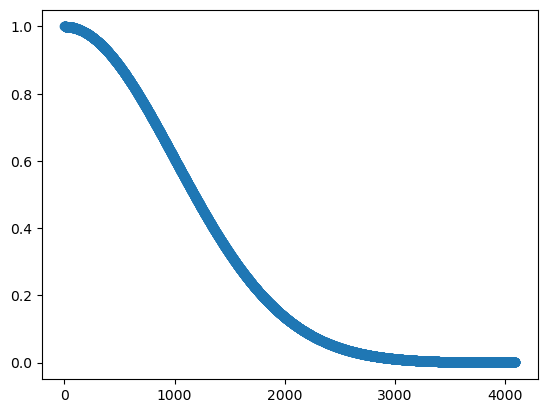

In [60]:
plt.scatter(np.arange(2**12), tensors_multiplication(gauss_mps(3, 9, 0.0000005)))
plt.plot(np.arange(2**12), np.exp(-0.0000005 * (np.arange(2**12))**2))  